<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/red_wine_quality_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red wine quality classification

In [2]:
! pip install -q kaggle
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d 'uciml/red-wine-quality-cortez-et-al-2009'

Saving kaggle.json to kaggle.json
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 18.3MB/s]


In [3]:
%%bash
mkdir -p /content/data
unzip /content/red-wine-quality-cortez-et-al-2009.zip -d /content/data/

Archive:  /content/red-wine-quality-cortez-et-al-2009.zip
  inflating: /content/data/winequality-red.csv  


In [4]:
import pandas as pd

data = pd.read_csv('/content/data/winequality-red.csv')

In [5]:
data.shape

(1599, 12)

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop("quality", axis=1)
y = data["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Data exploration

In [7]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1133,7.2,0.48,0.07,5.5,0.089,10.0,18.0,0.99684,3.37,0.68,11.2
279,8.9,0.40,0.32,5.6,0.087,10.0,47.0,0.99910,3.38,0.77,10.5
433,12.3,0.39,0.63,2.3,0.091,6.0,18.0,1.00040,3.16,0.49,9.5
1119,5.6,0.66,0.00,2.5,0.066,7.0,15.0,0.99256,3.52,0.58,12.9
1162,8.5,0.32,0.42,2.3,0.075,12.0,19.0,0.99434,3.14,0.71,11.8


In [8]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.313213,0.526884,0.271024,2.515872,0.087959,15.716966,46.340891,0.996723,3.310641,0.660837,10.425059
std,1.730403,0.179873,0.194970,1.361332,0.050247,10.126336,33.120629,0.001909,0.154199,0.175821,1.040307
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995575,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.430000,2.600000,0.090000,21.000000,61.000000,0.997800,3.400000,0.730000,11.100000
max,15.600000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


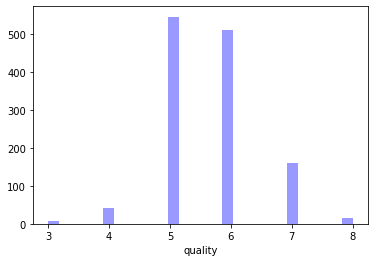

In [9]:
import seaborn as sns

sns.distplot(y_train, kde=False, color='blue')


In [10]:
y_train.value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [11]:
combined = pd.concat([X_train, y_train], axis=1)

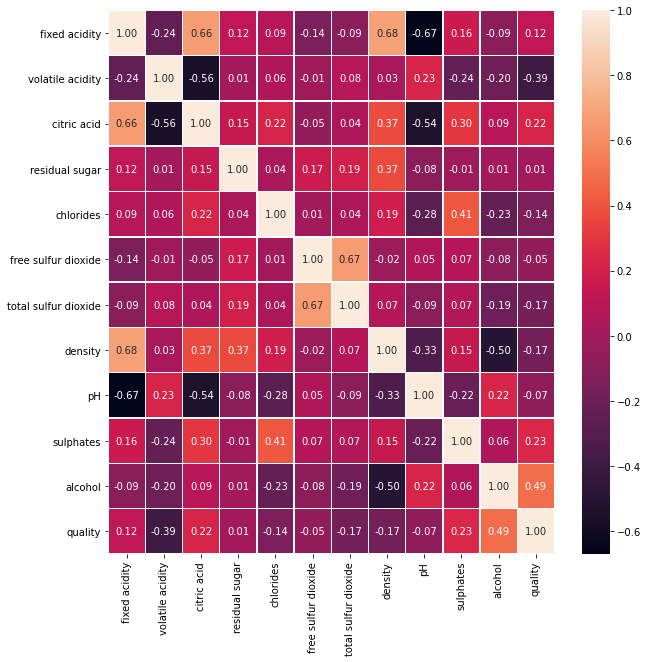

In [12]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(figsize = (10,10))

sns.heatmap(combined.corr(), annot = True, linewidths=.5, fmt = ".2f", ax=axes)
plt.show()

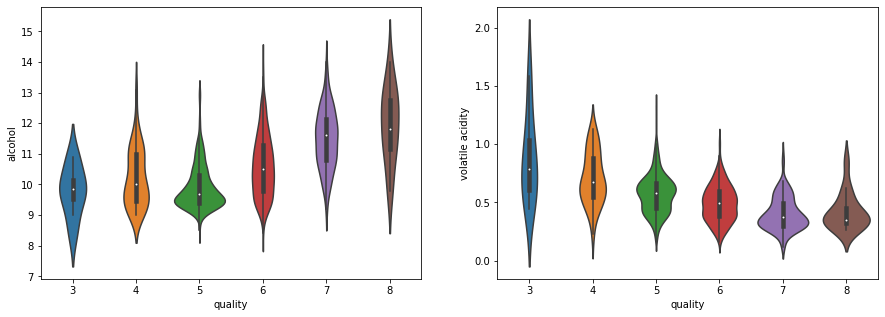

In [13]:
fig, axes = plt.subplots(1, 2, figsize =(15,5))

def violin(feature, ax):
  sns.violinplot(x='quality',
                 y=feature,
                 sizes=(10, 200),
                 data=combined,
                 ax=ax)

violin('alcohol', axes[0])
violin('volatile acidity', axes[1])

Since standard coefficient correlation captures only linear correlations, plot the pairs to detect nonlinear correlations.


In [14]:
combined['quality'].value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [16]:
x = combined.groupby(pd.cut(combined['quality'], bins=[1, 3, 7, 10]))
bin_keys = x.groups.keys()
labels = { 1: 'Bad', 2: 'Mediocre', 3: 'Good' }

tmp = combined.copy()
for i, b in enumerate(bin_keys, 1):
  idx = x.groups.get(b)
  tmp.loc[idx, 'quality'] = labels[i]

tmp.head()
tmp['quality'].value_counts()

Mediocre    1256
Good          15
Bad            8
Name: quality, dtype: int64

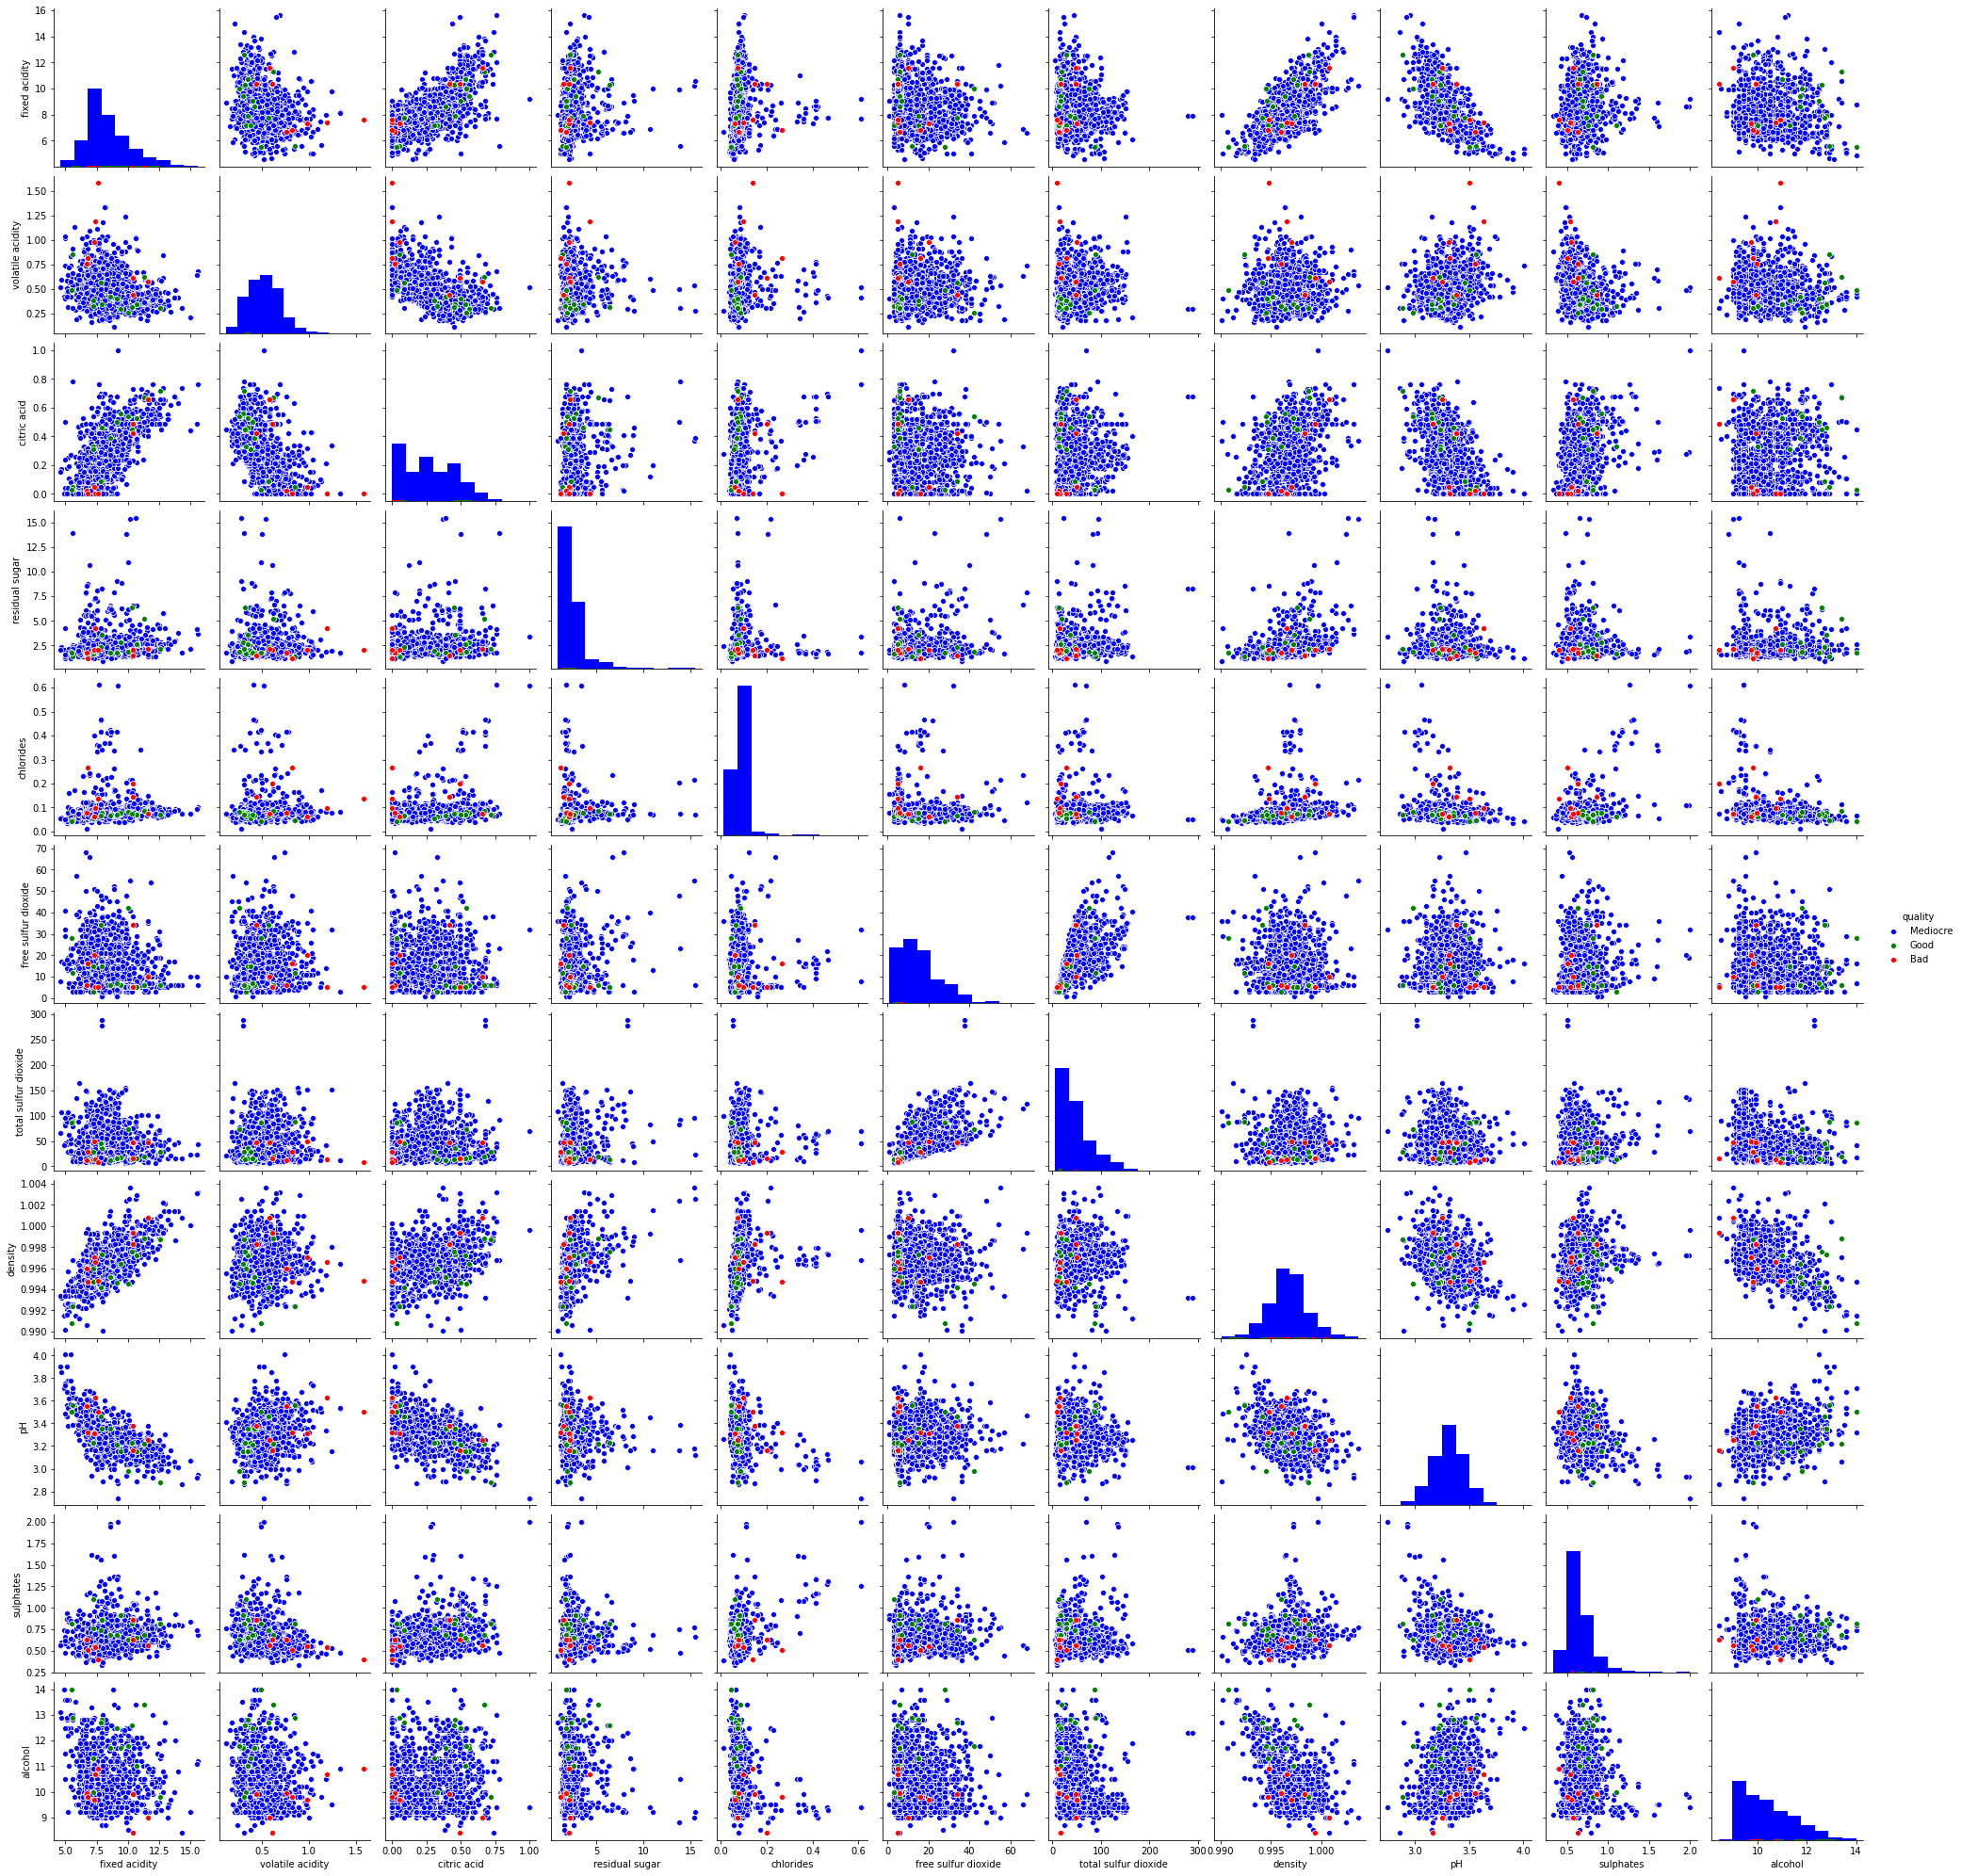

In [17]:
sns.pairplot(tmp, hue='quality', diag_kind='hist', palette={'Bad': 'red', 'Mediocre': 'blue', 'Good': 'green'})

## Models

Models to try:

1. Logistic regression

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV

logreg = Pipeline([
    ('Scaler', StandardScaler(with_mean=False)),
    ('LogReg', LogisticRegressionCV(cv=5, max_iter=1000))
  ])

In [52]:
logreg.fit(X_train, y_train)
result = logreg.score(X_train, y_train)

print(result)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6145426114151681


In [26]:
"""
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5
seed = 42

results, names = [], [] 
pipelines = [logreg]

for name, model in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
"""

'\nfrom sklearn.model_selection import KFold, cross_val_score\n\nn_folds = 5\nseed = 42\n\nresults, names = [], [] \npipelines = [logreg]\n\nfor name, model in pipelines:\n    kfold = KFold(n_splits=n_folds, random_state=seed)\n    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)    \n    names.append(name)\n    results.append(cv_results)    \n    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())\n    print(msg)\n'

## Evaluation metric